Business Problem: When it comes to demand of an item, usually follows the economic rule: as price drops, demand increases and vice versa. 

I recently did an analysis at work that looked at 5 different categories from the highest grossing GMV categories and the most searched item. And it was surprising to see user behavior as price dropped. For some categories, users were insensitive to price drops. They would buy an athletic apparel at whatever cost because of brand affinity. This analysis on an Indian market for fitness trackers follows the same goal.

Metric want to lift: Gross Merchandise Value by seeing which categories are inelastic and therefore, have the highest potential for long-term revenue gain.

# Hypothesis: 

For items that are not necessary, such as commodities demand could go up if price goes down. If an item is a day-to-day necessity then demand will be consistent and possibly even grow despite change in price. An example of this is gas. 

# Analytic Approach:
1. Take a look at highest grossing categories  
2. Examine user behavior/demand as price changes 
3. Perform linear regression on change in price results in what change in user behavior
4. Look at location as an indicator of who is most price elastic/inelastic

In [67]:
import random
import numpy as np
import pandas as pd

import matplotlib.dates as dates
from datetime import datetime

import altair as alt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from sklearn.linear_model import LinearRegression

In [68]:
# df = pd.read_csv('../input/ecommerce-events-history-in-electronics-store/events.csv', engine='python')
# df.head()

In [69]:
# def demand_time_graph():
    
#     categories = ['electronics.smartphone'
#               , 'appliances.kitchen.refrigerators'
#               , 'electronics.video.tv'
#               , 'computers.notebook'
#               , 'appliances.environment.vacuum'
#               , 'electronics.audio.headphone']
    
#     for c in categories:
#         category_df = df2_agg_time_no_nulls.loc[df2_agg_time_no_nulls['category_code'] == c]
#         category_df = category_df.loc[category_df['event_time'].str.startswith('202')]
#         category_df['event_time'].min(),category_df['event_time'].max()
#         fig = go.Figure(data=go.Scatter(x=category_df['event_time'], 
#                                     y=category_df['total_tx'],
#                                     marker_color='red', text="sales"))

#         fig.update_layout({
#                        "xaxis": {"title":"Date"},
#                        "yaxis": {"title":"Total Sold"},
#                        "showlegend": False})
#         print('Total Sales by date for ', c)
#         fig.show()
# demand_time_graph()

# Health Tracker Product Sales in India

## EDA

In [70]:
health = pd.read_csv('../input/fitness-trackers-products-ecommerce/Fitness_trackers_updated.csv')
health.head()

,Brand Name,Device Type,Model Name,Color,Selling Price,Original Price,Display,Rating (Out of 5),Strap Material,Average Battery Life (in days),Reviews
0,Xiaomi,FitnessBand,Smart Band 5,Black,"2,499","2,999",AMOLED Display,4.1,Thermoplastic polyurethane,14,NaN
1,Xiaomi,FitnessBand,Smart Band 4,Black,"2,099","2,499",AMOLED Display,4.2,Thermoplastic polyurethane,14,NaN
2,Xiaomi,FitnessBand,HMSH01GE,Black,"1,722","2,099",LCD Display,3.5,Leather,14,NaN
3,Xiaomi,FitnessBand,Smart Band 5,Black,"2,469","2,999",AMOLED Display,4.1,Thermoplastic polyurethane,14,NaN
4,Xiaomi,FitnessBand,Band 3,Black,"1,799","2,199",OLED Display,4.3,Plastic,7,NaN


In [71]:
#Add random dates to get some fake trends
def random_dates(start, end, n, unit='D', seed=None):
    if not seed:  
        np.random.seed(0)

    ndays = (end - start).days + 1
    return pd.to_timedelta(np.random.rand(n) * ndays, unit=unit) + start

np.random.seed(0)
start = pd.to_datetime('2022-01-01')
end = pd.to_datetime('2022-10-20')
random_dates(start, end, 248)

health['event_date'] = random_dates(start, end, 610)

health['event_date'] = health['event_date'].apply(lambda s: str(s)[0:10])

In [72]:
#Adding fake locations
health['region'] = pd.Series(
    random.choices(['Mumbai', 'Delhi', 'Bangalore', 'Kolkata', 'Chennai', 'Hyderabad', 'Pune', 'Ahemdabad', 'Surat', 'Kumpar'], weights=[10, 6, 5, 4, 1, 1, 1, 1, 1, 1], k=len(health)), 
    index=health.index
)

In [73]:
health.dtypes

Brand Name                         object
Device Type                        object
Model Name                         object
Color                              object
Selling Price                      object
Original Price                     object
Display                            object
Rating (Out of 5)                 float64
Strap Material                     object
Average Battery Life (in days)      int64
Reviews                            object
event_date                         object
region                             object
dtype: object

In [74]:
#Formatting Price Columns
health["Selling Price"] = health["Selling Price"].str.replace(',','').astype(int)
health["Original Price"] = health["Original Price"].str.replace(',','').astype(int)
health.dtypes

Brand Name                         object
Device Type                        object
Model Name                         object
Color                              object
Selling Price                       int64
Original Price                      int64
Display                            object
Rating (Out of 5)                 float64
Strap Material                     object
Average Battery Life (in days)      int64
Reviews                            object
event_date                         object
region                             object
dtype: object

In [75]:
#Data Integrity
health.isnull().sum()

Brand Name                          0
Device Type                         0
Model Name                          0
Color                               0
Selling Price                       0
Original Price                      0
Display                             0
Rating (Out of 5)                  56
Strap Material                      0
Average Battery Life (in days)      0
Reviews                           496
event_date                          0
region                              0
dtype: int64

In [76]:
health.describe()

,Selling Price,Original Price,Rating (Out of 5),Average Battery Life (in days)
count,610.000000,610.000000,554.000000,610.000000
mean,20706.859016,23977.503279,4.195668,8.926230
std,19803.690357,20242.634014,0.422576,7.632107
min,799.000000,1599.000000,2.000000,1.000000
25%,6995.000000,10249.000000,4.000000,2.000000
50%,14999.000000,18995.000000,4.200000,7.000000
75%,27467.500000,31416.750000,4.500000,14.000000
max,122090.000000,122090.000000,5.000000,45.000000


## Health Tracker Qualities also through the Lens of Highest Grossing

In [77]:
brand = health['Brand Name'].value_counts()
brand

FOSSIL             133
GARMIN             101
APPLE               86
FitBit              51
SAMSUNG             48
huami               36
Huawei              26
Noise               20
Honor               20
Fire-Boltt          14
realme              12
Zebronics           12
Xiaomi              10
Crossbeats           8
Fastrack             6
boAt                 5
Ptron                5
GOQii                4
OnePlus              3
Oppo                 2
Noise                2
LCARE                2
dizo by realme       2
LAVA                 1
Infinix              1
Name: Brand Name, dtype: int64

In [78]:
fig = px.pie(brand, values=brand.values, names=brand.index)
fig.show()

In [79]:
type = health['Device Type'].value_counts()
type

Smartwatch     533
FitnessBand     77
Name: Device Type, dtype: int64

In [80]:
fig = px.pie(type, values=type.values, names=type.index)
fig.show()

From a top aggregate level, FOSSIL and smartwatches are the biggest players in the market.

## What are the top 6 grossing tracker models?

In [81]:
brand_agg = health.groupby('Brand Name') \
       .agg({'Brand Name':'size', 'Selling Price':'sum', 'Original Price':'sum'}) \
       .rename(columns={'Brand Name':'total_tx','Selling Price':'total_sell_price', 'Original Price':'total_original_price'}) \
       .reset_index()

top6_gross = brand_agg.sort_values(['total_sell_price'], ascending=[False])[:6]
top6_gross

,Brand Name,total_tx,total_sell_price,total_original_price
0,APPLE,86,4249590,4396960
6,GARMIN,101,3538861,4052214
2,FOSSIL,133,1838719,2232374
18,SAMSUNG,48,1099266,1295077
5,FitBit,51,714961,887887
9,Huawei,26,412740,539540


Apple is not a suprise since it makes high quality products retailed at high prices. which many adore (brand affinity).

In [82]:
top6_grossing = health.loc[health['Brand Name'].isin(top6_gross['Brand Name'])]

brands = top6_gross['Brand Name'].value_counts().index
brands_dfs = []
for brand in brands:
    
    df = top6_grossing.loc[top6_grossing['Brand Name'] == brand]
    brands_dfs.append(df)

In [83]:
lr_dfs = []
def agg_df (df):
    date_region_agg = df.groupby(['event_date', 'region']) \
       .agg({'Brand Name':'size', 'Selling Price':'mean', 'Original Price':'mean'}) \
       .rename(columns={'Brand Name':'total_tx','Selling Price':'avg_sell_price', 'Original Price':'avg_original_price'}) \
       .reset_index()
    
    region_agg = date_region_agg.groupby("region")[["avg_sell_price", "total_tx"]].transform("median")
    date_region_agg["priceDelta"] = (date_region_agg["avg_sell_price"] - region_agg["avg_sell_price"]) / region_agg["avg_sell_price"]
    date_region_agg["demandDelta"] = (date_region_agg["total_tx"] - region_agg["total_tx"]) / region_agg["total_tx"]
    
    lr_dfs.append(date_region_agg)

for df in brands_dfs:
    agg_df(df)

## Discounts have correlation with price point?

In [84]:

alt.Chart(health, title="Original Price vs Selling Price").mark_point(filled=True,size=40).encode(
    x='Original Price',
    y='Selling Price',
    color='Brand Name',
    tooltip=['Brand Name', 'Selling Price', 'Original Price']
).interactive()

alt.Chart(...)

Those brands that fall on the diagonal line have no difference between the asking price and price when it was sold. Not a surprise that Apple dominates that line. It does not depreciate much. For those brands below the diagonal price got discounted, which means the seller thought that for the item to sell in a reasonable time, price reduction would be best. Brands that were most discounted the most were GARMIN, FOSSIL and Huawei.

Also, Apple and GARMIN seem to have the most products at different price tiers. GARMIN is Apple's biggest competitor for variable products though it has more discounts versus Apple. 

Let's take a look at market behavior with another visualization.

In [85]:
agg = health.groupby(['Brand Name', 'Model Name']) \
       .agg({'Model Name':'size', 'Selling Price':'mean', 'Original Price':'mean'}) \
       .rename(columns={'Model Name':'model_total_tx','Selling Price':'avg_model_sell_price', 'Original Price':'avg_model_original_price'}) \
       .reset_index()

agg.sort_values(['model_total_tx'], ascending=[False]) 

,Brand Name,Model Name,model_total_tx,avg_model_sell_price,avg_model_original_price
181,FitBit,Charge 2,8,11436.375000,14999.0
132,FOSSIL,Gen 5 Julianna HR,6,17161.666667,21495.0
135,FOSSIL,Jacqueline Hybrid,5,10455.200000,12895.0
402,huami,Amazfit Bip,5,5569.200000,6675.4
412,huami,Amazfit GTS,4,5574.000000,12999.0
...,...,...,...,...,...
155,FOSSIL,Rose Gold Smart,1,21995.000000,21995.0
154,FOSSIL,Rose Gold HR,1,21995.000000,21995.0
151,FOSSIL,Q Neely,1,6995.000000,12995.0
150,FOSSIL,Q Machine,1,10796.000000,13495.0


In [86]:
alt.Chart(agg, title="Average Original Model Price vs Model Total Demand").mark_point(filled=True,size=40).encode(
    x='avg_model_original_price',
    y='model_total_tx',
    color='Brand Name',
    tooltip=['Brand Name', 'model_total_tx', 'avg_model_original_price']
).interactive()

alt.Chart(...)

We can see here that as price incrases, there are less transactions/orders. Looks like Apple and GARMIN have similar variety of products with different price points. Though market seems hotter for GARMIN.

This graph seems to follow the economic law that as price increases, demand decreases. However, high priced GARMIN products broke that rule.

## Top 5 brands split by device type offerings.

<AxesSubplot:xlabel='count', ylabel='Brand Name'>

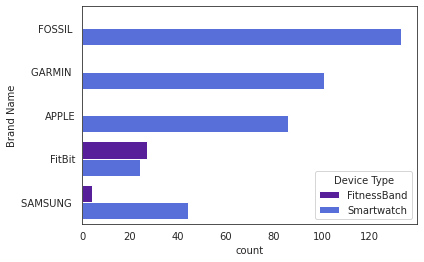

In [87]:
sns.set_style('white')
sns.countplot(y="Brand Name", hue="Device Type", data=health, palette=["#560bad","#4361EE"],
              order=health["Brand Name"].value_counts().iloc[:5].index)

In [88]:
prod_offerings = health.groupby('Brand Name')['Model Name'].nunique().sort_values(ascending=False).reset_index(name='count')
fig = px.pie(prod_offerings, values=prod_offerings['count'], names=prod_offerings['Brand Name'])
fig.show()

Suprisingly, FOSSIL has the most product offerings with GARMIN and Apple not far behind. Though FOSSIL has more product offerings, they are all at similar tiered price. 

Now let's examine what differentiates these products/brand moats.

## Let's see the most popular Color, Display, Strap Material and Average Battery Life (in days).

In [89]:
tracker_qualities = ['Color', 'Display', 'Strap Material', 'Average Battery Life (in days)']

for x in tracker_qualities:

    fig = px.bar(health, health[x].value_counts().index, y=health[x].value_counts().values)
    print('Most popular fitness trackers\'', x)
    fig.show()

Most popular fitness trackers' Color


Most popular fitness trackers' Display


Most popular fitness trackers' Strap Material


Most popular fitness trackers' Average Battery Life (in days)


## How about the top 20 most grossing tracker qualities (what types of fitness trackers are consumers spending the most on)?

In [90]:
for x in tracker_qualities:

    df = health.loc[health['Brand Name'].isin(top6_gross['Brand Name'].value_counts().index)]
    print(x, 'value counts')
    print('')
    print(df[x].value_counts())
    print('')
    print('')
    fig = px.bar(df, df[x].value_counts().index, y=df[x].value_counts().values)
    print('Highest grossing fitness trackers\'', x)
    fig.show()

Color value counts

Black             137
Blue               26
Silver             25
Gold               20
Grey               18
                 ... 
Black, Silver       1
Multicolor          1
Silver, Black       1
Blue, Black         1
Green               1
Name: Color, Length: 122, dtype: int64


Highest grossing fitness trackers' Color


Display value counts

AMOLED Display         271
OLED Retina Display     86
OLED Display            29
LED Display             28
PMOLED Display          19
LCD Display             11
TFT-LCD Display          1
Name: Display, dtype: int64


Highest grossing fitness trackers' Display


Strap Material value counts

Silicone                      164
Stainless Steel                97
Leather                        57
Aluminium                      57
Elastomer                      44
Nylon                          10
Rubber                          9
Thermoplastic polyurethane      4
Fabric                          1
leather                         1
Leather                         1
Name: Strap Material, dtype: int64


Highest grossing fitness trackers' Strap Material


Average Battery Life (in days) value counts

14    127
1     117
7      88
2      52
12     25
30     12
5       9
45      8
10      3
3       2
6       2
Name: Average Battery Life (in days), dtype: int64


Highest grossing fitness trackers' Average Battery Life (in days)


So looks like highest grossing fitness tracker qualities are: black, AMOLED display, Silicone with average batt lifespan of 14 days. Best to keep this mind when looking at where to invest R&D/production budget.

## Reviews

Let's see which Brands have the most buzz (reviews). This helps business see which products have the strongest appeal or lowest appeal since those who leave reviews are usually those who think they got a highly valued product or were jipped. For the strongest appeal, good to have those products very visible in the search impression (top ranking) since have the best reputation and drop those products from shop that have lowest ratings. Caveat here may be the poor get poorer and the rich get richer, but can work around this by allowing users to have a filter that filters on price to customize a customers' search results.

In [91]:
# Total ratings by Brand
round(health.groupby('Brand Name')['Reviews'].size().sort_values(ascending=False).iloc[:10],1)

Brand Name
FOSSIL        133
GARMIN        101
APPLE          86
FitBit         51
SAMSUNG        48
huami          36
Huawei         26
Noise          20
Honor          20
Fire-Boltt     14
Name: Reviews, dtype: int64

## Average Ratings

Lastly, with ratings, let's see which ones have the highest quality regardless of number of ratings. These give insight into brand affinity and $$ for value.

In [92]:
#average ratings by Brand
round(health.groupby('Brand Name')['Rating (Out of 5)'].mean().sort_values(ascending=False).iloc[:10],1)

Brand Name
APPLE              4.5
OnePlus            4.3
dizo by realme     4.2
FOSSIL             4.2
SAMSUNG            4.2
Honor              4.2
FitBit             4.2
Xiaomi             4.2
Huawei             4.2
huami              4.2
Name: Rating (Out of 5), dtype: float64

Apple has the highest ratings. This explains why Apple owners say once you get into their ecosystem, it is hard to get out.

Lastly, let's take a look at our original question: how does change in price correspond to change of demand. Another question want to answer now is that with change of price, does that change customers' asessement of value of product they bought.

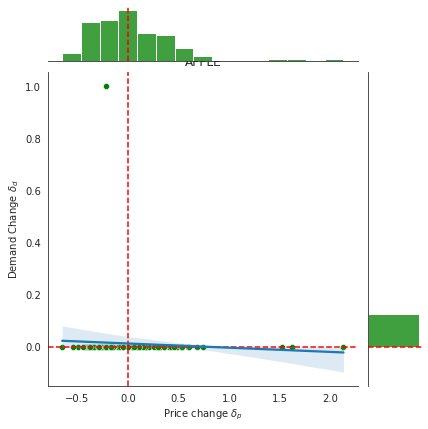

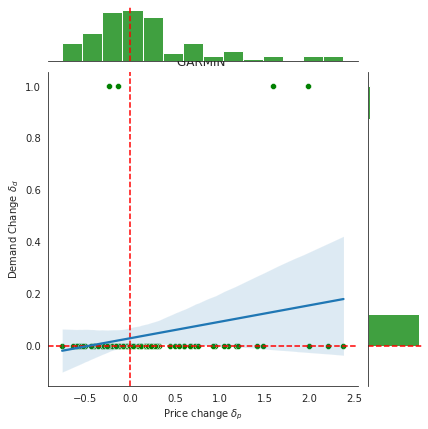

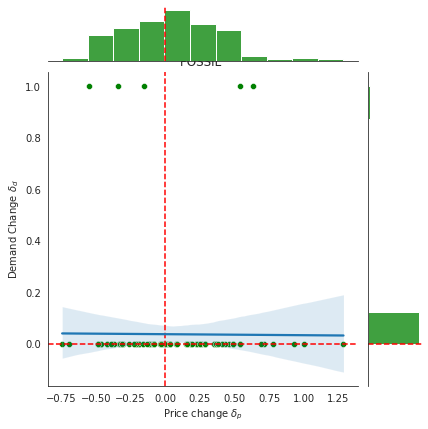

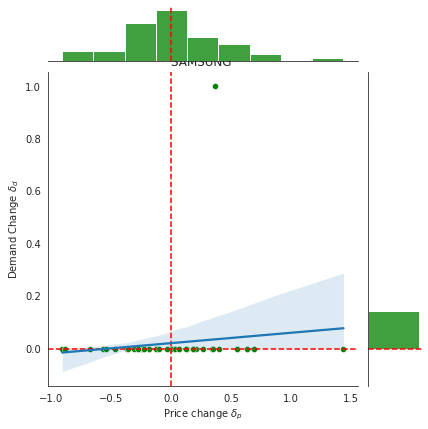

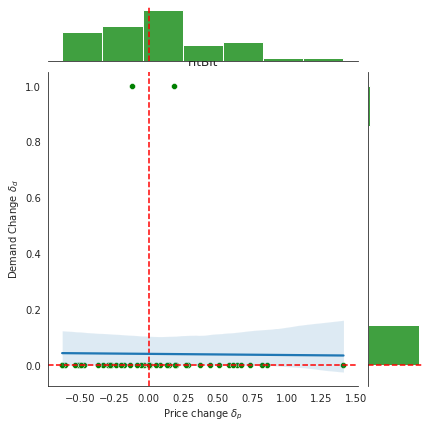

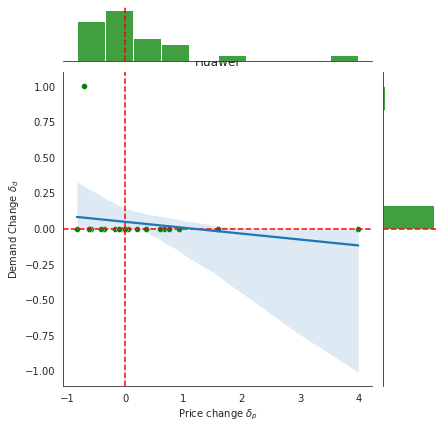

In [93]:
df_dict = dict(zip(top6_gross['Brand Name'].value_counts().index, lr_dfs))
for k,v in df_dict.items():
    
    g = sns.jointplot(data=v, x="priceDelta", y="demandDelta", color="green")
    g.refline(
        x=v["priceDelta"].median(),
        y=v["demandDelta"].median(), 
        color="red")
    sns.regplot(data=v, x="priceDelta", y="demandDelta", scatter=False, ax=g.ax_joint).set_title(k)
    g.ax_joint.set(
        xlabel=r"Price change $\delta_p$",
        ylabel=r"Demand Change $\delta_d$"
    )

# How to interpret price elasticity?
### There are five zones of elasticity. Products and services can be:

𝐸𝑑=0 ：Perfectly Inelastic.
Where the quantity demanded does not change when the price changes. Products in this category are things consumers absolutely need and there are no other options from which to obtain them.

0<|𝐸𝑑|<1 : Inelastic.
Where 1% of changes in price cause small changes in demand (less than 1%). Gasoline is a good example here because most people need it, so even when prices go up, demand doesn’t change greatly. Products with stronger brands tend to be more inelastic.

|𝐸𝑑|=1 : Unitarily Elastic.
Where any 1% change in price is matched by an equal change in quantity (equal to 1%).

1<|𝐸𝑑|<∞ : Elastic.
Where 1% changes in price cause large changes in quantity demanded (greater than 1%). Beef is an example of a product that is relatively elastic.

𝐸𝑑=∞ : Perfectly Elastic.
Where any very small change in price results in a very large change in the quantity demanded. Products that fall in this category are mostly “pure commodities,” says Avery. “There’s no brand, no product differentiation, and customers have no meaningful attachment to the product.”

References:
* Harvard Business Review
* Wiki

By the above definitions, looks like the top grossing fitness trackers are inelastic.

In [94]:
for k,v in df_dict.items():
    
    lm = LinearRegression()
    lm.fit(v["priceDelta"].values.reshape(-1, 1), v["demandDelta"])
    print('Linear Regression coefficient for', k, 'is:', lm.coef_)

Linear Regression coefficient for APPLE is: [-0.01614374]
Linear Regression coefficient for GARMIN  is: [0.0633632]
Linear Regression coefficient for FOSSIL  is: [-0.00394593]
Linear Regression coefficient for SAMSUNG  is: [0.03955573]
Linear Regression coefficient for FitBit is: [-0.00416034]
Linear Regression coefficient for Huawei is: [-0.04141445]


Almost all are close to 0 which means the quantity demanded does not change as price changes. Demand is in general inelastic even though FOSSIL and SAMSUNG showed relatively larger elasticity. Though numbers are still small in general. So those brands' demand would not be considered elastic, but inelastic.

Now let us take a look at region level. How do they look when price changes.

In [95]:
elasticity_df = []
for k,v in df_dict.items():
    
    lm = LinearRegression()
    names = []
    elasticity = []
    g = v.groupby("region")
    for name, group in g:
        lm.fit(group["priceDelta"].values.reshape(-1, 1), group["demandDelta"])
        elasticity.append(lm.coef_)
        names.append(name)
    elasticity = np.array(elasticity)
    elasticity = pd.Series(elasticity.reshape(-1), index=np.array(names))
    elasticity = elasticity.sort_values()
    elasticity.name = "Elasticity"
    
    elasticity_df.append(elasticity)

In [96]:
elasticity_dict = dict(zip(top6_gross['Brand Name'].value_counts().index, elasticity_df))
for k,v in elasticity_dict.items():
    print(k)
    print('')
    print('')
    print(v.describe())
    print('')
    print('')

APPLE


count    9.000000
mean    -0.028850
std      0.086549
min     -0.259646
25%      0.000000
50%      0.000000
75%      0.000000
max      0.000000
Name: Elasticity, dtype: float64


GARMIN 


count    9.000000
mean     0.035854
std      0.087920
min     -0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      0.264653
Name: Elasticity, dtype: float64


FOSSIL 


count    10.000000
mean      0.000596
std       0.133878
min      -0.321434
25%       0.000000
50%       0.000000
75%       0.000000
max       0.210597
Name: Elasticity, dtype: float64


SAMSUNG 


count    7.000000
mean     0.038886
std      0.102883
min     -0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      0.272203
Name: Elasticity, dtype: float64


FitBit


count    8.000000
mean     0.035266
std      0.128704
min     -0.066425
25%     -0.000000
50%      0.000000
75%      0.000000
max      0.348555
Name: Elasticity, dtype: float64


Huawei


count    7.000000
mean    -0.039620
std 

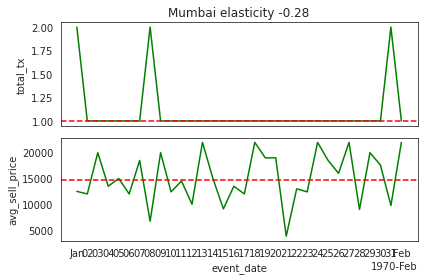

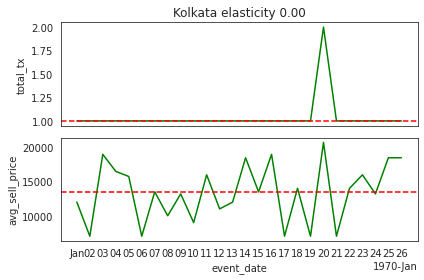

In [97]:
for region in elasticity_df[2].index[[0, -1]]:
    regions = lr_dfs[2][lr_dfs[2]["region"] == region]

    fig, (axd, axp) = plt.subplots(2, 1, tight_layout=True)
    sns.lineplot(data=regions, x="event_date", y="total_tx", color="green", estimator=np.median, ax=axd)
    sns.lineplot(data=regions, x="event_date", y="avg_sell_price", color="green", ax=axp)

    axd.set_title(f"{region} elasticity {elasticity.loc[region]:.2f}")
    # axp.set_title(f"{region} elasticity {elasticity[-1]:.2f}")
    axd.axhline(regions["total_tx"].median(), ls="--", color="r")
    axp.axhline(regions["avg_sell_price"].median(), ls="--", color="r")

    axd.set_xticklabels([])
    axd.set_xlabel('')
    axp.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(axp.xaxis.get_major_locator()))

We can see here that for FOSSIL products, price changes without demand changing much. Hence, the demand elasticity is 0. This is reflected at the aggregate level. 

## Lastly, let's see how the change of price affects change in rating (on scale of 1-5). 

We want to know whether or not a change in price also causes a change in rating. Does 'you get what you pay for' play out here or does a change in price not lead to a change in rating. This would mean rating is inelastic - there is a general consensus of quality of product regardless of different model type. This would be good signal for product QA.

In [98]:
rating_dfs = []
def agg_df (df):
    date_region_agg = df.groupby(['event_date', 'region']) \
       .agg({'Rating (Out of 5)':'mean', 'Selling Price':'mean', 'Original Price':'mean'}) \
       .rename(columns={'Rating (Out of 5)':'avg_rating','Selling Price':'avg_sell_price', 'Original Price':'avg_original_price'}) \
       .reset_index()

    date_region_agg.sort_values(['avg_rating'], ascending=[False]) 
    
    region_agg = date_region_agg.groupby("region")[["avg_sell_price", "avg_rating"]].transform("median")
    date_region_agg["priceDelta"] = (date_region_agg["avg_sell_price"] - region_agg["avg_sell_price"]) / region_agg["avg_sell_price"]
    date_region_agg["ratingDelta"] = (date_region_agg["avg_rating"] - region_agg["avg_rating"]) / region_agg["avg_rating"]
    
    rating_dfs.append(date_region_agg)

for df in brands_dfs:
    agg_df(df)

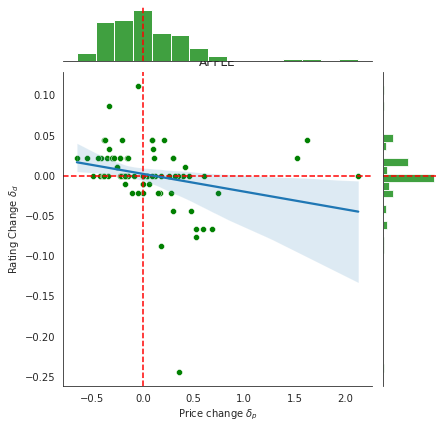

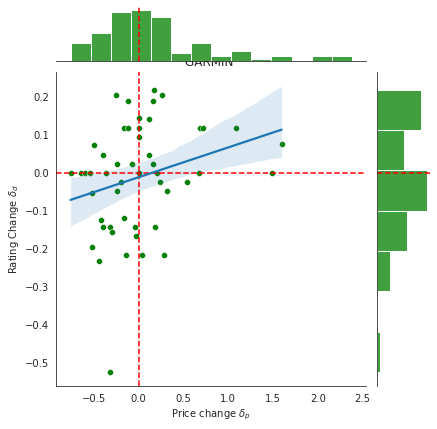

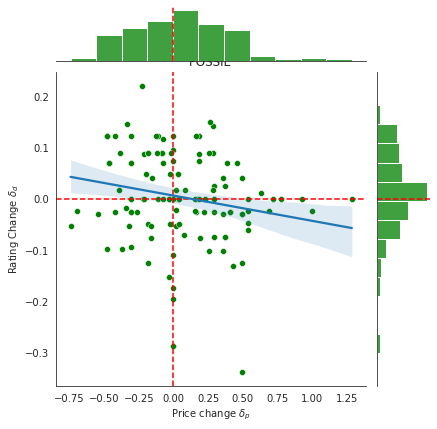

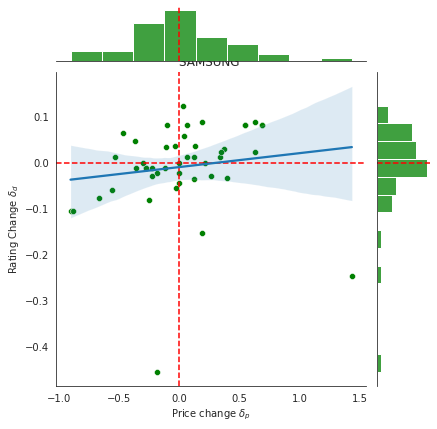

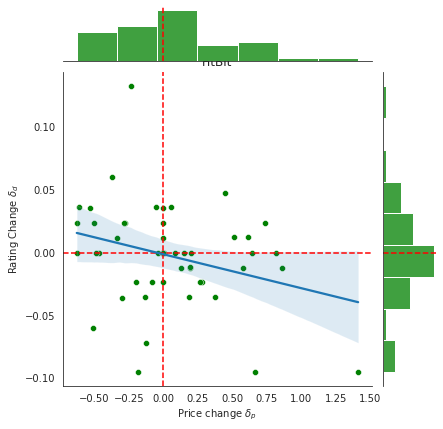

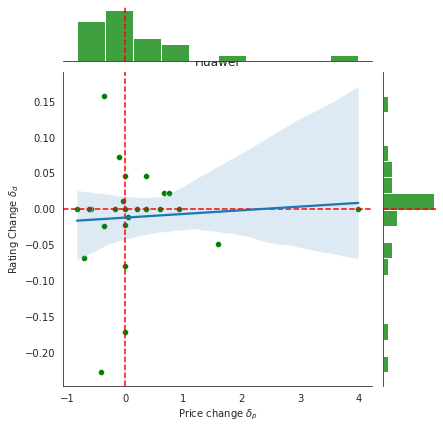

In [99]:
df_dict2 = dict(zip(top6_gross['Brand Name'].value_counts().index, rating_dfs))
for k,v in df_dict2.items():
    
    g = sns.jointplot(data=v, x="priceDelta", y="ratingDelta", color="green")
    g.refline(
        x=v["priceDelta"].median(),
        y=v["ratingDelta"].median(), 
        color="red")
    sns.regplot(data=v, x="priceDelta", y="ratingDelta", scatter=False, ax=g.ax_joint).set_title(k)
    g.ax_joint.set(
        xlabel=r"Price change $\delta_p$",
        ylabel=r"Rating Change $\delta_d$"
    )

The story is not the same for ratings vs price. Change in price causes change in ratings. From the graphs, only GARMIN, Samsung and Huawei have positive reviews as price increases. Surprising this is not the case for Apple, Fossil and FitBit since they have fairly good reputation for quality product.

In [100]:
elasticity_df2 = []
for k,v in df_dict2.items():
    v=v.fillna(0)
    lm = LinearRegression()
    names = []
    elasticity = []
    g = v.groupby("region")
    for name, group in g:
        lm.fit(group["priceDelta"].values.reshape(-1, 1), group["ratingDelta"])
        elasticity.append(lm.coef_)
        names.append(name)
    elasticity = np.array(elasticity)
    elasticity = pd.Series(elasticity.reshape(-1), index=np.array(names))
    elasticity = elasticity.sort_values()
    elasticity.name = "Elasticity"
    
    elasticity_df2.append(elasticity)

In [101]:
elasticity_dict2 = dict(zip(top6_gross['Brand Name'].value_counts().index, elasticity_df2))
for k,v in elasticity_dict2.items():
    print(k)
    print('')
    print('')
    print(v.describe())
    print('')
    print('')

APPLE


count    9.000000
mean    -0.039513
std      0.078723
min     -0.236216
25%     -0.036604
50%     -0.025604
75%      0.000000
max      0.035328
Name: Elasticity, dtype: float64


GARMIN 


count    9.000000
mean     0.003930
std      0.043727
min     -0.100503
25%      0.000000
50%      0.000000
75%      0.033237
max      0.052302
Name: Elasticity, dtype: float64


FOSSIL 


count    10.000000
mean      0.023532
std       0.120134
min      -0.116333
25%      -0.058706
50%       0.007101
75%       0.057141
max       0.301844
Name: Elasticity, dtype: float64


SAMSUNG 


count    7.000000
mean     0.004956
std      0.090302
min     -0.112716
25%     -0.059268
50%      0.000000
75%      0.067468
max      0.131008
Name: Elasticity, dtype: float64


FitBit


count    8.000000
mean    -0.030130
std      0.038139
min     -0.083955
25%     -0.067573
50%     -0.016644
75%     -0.001737
max      0.016606
Name: Elasticity, dtype: float64


Huawei


count    7.000000
mean    -0.066331
std 

Interesting, we see here that as price changed for top grossing Apple, FOSSIL, FitBit and Huawei ratings went down. And with the rest, they are positive. This means that as GARMIN and Samsung buyers bought higher ended products, they were satisfied. However, with the brands that got lower ratings as price increased, Apple, FOSSIL, FitBit and Huawei buyers did not feel they were getting what they paid for. That is a friction point.

## Final Thoughts and Possible Next Steps:

1. Demand does not change mostly as price changes for top 6 selling brands indicating brand affinity. This pattern does not change when we look at location either. 
2. The story changed though when we looked at ratings. As price increased, the top grossing brand, Apple grew in negative ratings. This means that their lower end products may be eating their more luxury products or the high end products have not gained enough traction in the market/has not had enough iterations in R&D.
3. Future analysis would be combining when a demand in one product goes down due to economic climate, does demand in another competing product category increase. This would involve matrices. Something similar to when lululemon prices increase, fabletics/substitute demand increases.